In [1]:
import cv2
import csv
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pylab as pl
from skimage.filters import gaussian
from scipy import spatial
from sklearn.neighbors import KDTree
import bobsegutils as bsu
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave

Populating the interactive namespace from numpy and matplotlib


In [2]:
image_path = '/Users/prakash/Desktop/BobSegMarkData/2018-05-01_fromMark/MAX_C1-20180501_mNG-NMY-2_mSc-PH_01-01_Myosin.tif'
src_img = imread(image_path)
img_size = src_img.shape
row_size = range(0,img_size[1])
col_size = range(0,img_size[2])
print(img_size)

(61, 836, 628)


### Non-Smooth Warping/Flow Estimation

In [3]:
with open('/Users/prakash/Desktop/MarkGT/Tracks_with_uncertainty_radius.csv', 'r') as f:
    reader = csv.reader(f)
    uncertainty_radius_list_full = list(reader)
uncertainty_radius_list_full = uncertainty_radius_list_full[1:]
uncertainty_radius_list_full=np.array(uncertainty_radius_list_full,integer)
uncertainty_radius_list_full = [item for sublist in uncertainty_radius_list_full for item in sublist]
# print(uncertainty_radius_list_full)

In [4]:
uncertainty_radius_list_full = np.array(uncertainty_radius_list_full)
zero_uncertainty_index = np.where(uncertainty_radius_list_full == 0)[0]
nonzero_uncertainty_index = np.where(uncertainty_radius_list_full != 0)[0]

In [5]:
### Reading only certain indices (with uncertainty readius = 0) for warping

with open('/Users/prakash/Desktop/MarkGT/Choices_Structured.csv') as sd:
    source_reader=csv.reader(sd)
    next(source_reader)
    certain_source_rows=[row for idx, row in enumerate(source_reader) if idx in zero_uncertainty_index]
    uncertain_source_rows = [row for idx, row in enumerate(source_reader) if idx in nonzero_uncertainty_index]

with open('/Users/prakash/Desktop/MarkGT/Tracks_Structured.csv') as td:
    target_reader=csv.reader(td)
    next(target_reader)
    certain_target_rows=[row for idx, row in enumerate(target_reader) if idx in zero_uncertainty_index]
    uncertain_target_rows=[row for idx, row in enumerate(target_reader) if idx in nonzero_uncertainty_index]

In [6]:
### Reading only uncercertain indices (with uncertainty readius !=0) for validation of warped flow

with open('/Users/prakash/Desktop/MarkGT/Choices_Structured.csv') as sd:
    source_reader=csv.reader(sd)
    next(source_reader)
    uncertain_source_rows = [row for idx, row in enumerate(source_reader) if idx in nonzero_uncertainty_index]

with open('/Users/prakash/Desktop/MarkGT/Tracks_Structured.csv') as td:
    target_reader=csv.reader(td)
    next(target_reader)
    uncertain_target_rows=[row for idx, row in enumerate(target_reader) if idx in nonzero_uncertainty_index]

with open('/Users/prakash/Desktop/MarkGT/Tracks_with_uncertainty_radius.csv') as fd:
    uncertainty_radius_reader=csv.reader(fd)
    next(uncertainty_radius_reader)
    uncertain_radius_rows=[row for idx, row in enumerate(uncertainty_radius_reader) if idx in nonzero_uncertainty_index]

In [7]:
certain_sshape = np.array(certain_source_rows,float)
certain_tshape = np.array(certain_target_rows, float)

uncertain_sshape = np.array(uncertain_source_rows, float)
uncertain_tshape = np.array(uncertain_target_rows, float)
uncertain_radius_list = np.array(uncertain_radius_rows, float)

In [8]:
certain_sshape = [tuple(l) for l in certain_sshape]
certain_tshape = [tuple(m) for m in certain_tshape]
certain_source = []
certain_target = []
certain_source.append(certain_sshape)
certain_target.append(certain_tshape)

uncertain_sshape = [tuple(l) for l in uncertain_sshape]
uncertain_tshape = [tuple(m) for m in uncertain_tshape]
uncertain_source = []
uncertain_target = []
uncertain_source.append(uncertain_sshape)
uncertain_target.append(uncertain_tshape)

In [9]:
validation_query_point_list = uncertain_sshape
validation_result_point_list = uncertain_tshape

In [10]:
filename = '/Users/prakash/Desktop/BobSegMarkData/2018-05-01_fromMark/MAX_C1-20180501_mNG-NMY-2_mSc-PH_01-01_Myosin.tif'
myosin_channel = imread(filename)
print('Shape of stack:', myosin_channel.shape)
sigma = [0.,2.,2.]
myosin_channel_smooth = gaussian(myosin_channel,sigma)

Shape of stack: (61, 836, 628)


In [11]:
flows = bsu.compute_flow( myosin_channel)
flow_x, flow_y = bsu.split_flow_components( flows )
avg_flow_x = bsu.flow_average(flow_x, 1)
avg_flow_y = bsu.flow_average(flow_y, 1)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

............................................................. ...done!


In [12]:
flow_points = []
for frame, points in enumerate(certain_source):
    print(frame)
    flow_points_per_frame = []
    for i in range(len(points)):
        position = bsu.update_pos(points[i], frame, avg_flow_x, avg_flow_y )
        flow_points_per_frame.append(position)
    flow_points.append(flow_points_per_frame)

0


In [13]:
starting_points_flat_list = [item for sublist in certain_source for item in sublist]
manual_track_points_flat_list = [item for sublist in certain_target for item in sublist]
flow_points_flat_list = [item for sublist in flow_points for item in sublist]

In [14]:
pixel_lag_X = []
pixel_lag_Y = []

for i in range(len(starting_points_flat_list)):
    r2_X = starting_points_flat_list[i][0]-flow_points_flat_list[i][0]
    r1_X = starting_points_flat_list[i][0]-manual_track_points_flat_list[i][0]
    position_offset_X = r2_X-r1_X
    pixel_lag_X.append(position_offset_X)
    
    r2_Y = starting_points_flat_list[i][1]-flow_points_flat_list[i][1]
    r1_Y = starting_points_flat_list[i][1]-manual_track_points_flat_list[i][1]
    position_offset_Y = r2_Y-r1_Y
    pixel_lag_Y.append(position_offset_Y)    

In [15]:
k_list = list(range(1,15))
print(k_list)
# k_list =[2]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [16]:
def kNN_weight_definition(k_value, distance, neighbor_index):
    """ Finds kNN depending on user specified k and defines weights for these neighbors inversly proportional to the 
        distance of neighbors from the queried point.
    """
    weight_list = []
    normalized_weight_vector = []
    sum_of_weights = 0
    distance_squared = distance*distance
    distance_inverse = 1/(distance_squared+0.001)
    
    for i in range (0,k_value):
        weight =  distance_inverse[0][i]
        sum_of_weights =  sum_of_weights+weight
        weight_list.append(weight)
        
    for j in range(0,len(weight_list)):
        normalized_weight = weight_list[j]/sum_of_weights
        normalized_weight_vector.append(normalized_weight)
        
    return normalized_weight_vector

In [17]:
def compensate_optical_flow(k_value):
    """Compensates computed optical flow by non smooth warping
    """
    for flow_row in range(0, flow_x.shape[1]):
        for flow_col in range(0, flow_x.shape[2]):
            pt = [flow_col, flow_row]  # <-- the point to find
            tree = KDTree(starting_points_flat_list)
            distance, neighbor_index = tree.query([pt], k_value)
            normalized_weight_vector = kNN_weight_definition (k_value, distance, neighbor_index)
            compensation_in_flow_x = 0
            compensation_in_flow_y = 0

            for i in range(0,k_value):
                compensation_in_flow_x = compensation_in_flow_x + normalized_weight_vector[i]*pixel_lag_X[neighbor_index[0][i]]
                compensation_in_flow_y = compensation_in_flow_y + normalized_weight_vector[i]*pixel_lag_Y[neighbor_index[0][i]]

            avg_flow_x_copy[0][flow_row][flow_col] = avg_flow_x_copy[0][flow_row][flow_col] + compensation_in_flow_x

            avg_flow_y_copy[0][flow_row][flow_col] = avg_flow_y_copy[0][flow_row][flow_col] + compensation_in_flow_y
            
    return avg_flow_x_copy, avg_flow_y_copy

In [18]:
def prepare_flow_list_for_validation(compensated_avg_flow_x, compensated_avg_flow_y):
    warped_flow_points = []
    for frame, points in enumerate(uncertain_source):
        print(frame)
        warped_flow_points_per_frame = []
        for i in range(len(points)):
            warped_position = bsu.update_pos(points[i], frame, compensated_avg_flow_x, compensated_avg_flow_y )
            warped_flow_points_per_frame.append(warped_position)
        warped_flow_points.append(warped_flow_points_per_frame)
    warped_flow_points_flat_list = [item for sublist in warped_flow_points for item in sublist]
    return warped_flow_points_flat_list
    # print(warped_flow_points_flat_list)

In [19]:
def delta_quantification(flow_results_list):
    center_to_manual_vectors = bsu.subVector(validation_query_point_list, validation_result_point_list)
    center_to_flow_vectors = bsu.subVector(validation_query_point_list, flow_results_list)
    delta = []
    for i in range(len(center_to_manual_vectors)):
        angle_rad = bsu.angle_between( center_to_flow_vectors[i], center_to_manual_vectors[i])
        angle_deg = math.degrees(angle_rad)
        delta.append(angle_deg)
    nanlist=[]
    for ii in range(len(delta)):
        if numpy.isnan(delta[ii]):
            nanlist.append(ii)
            delta[ii]=0
    return delta

In [20]:
def lag_quantification(warped_flow_points_flat_list):
    pixel_lag = []
    relative_pixel_lag = []
    count = 0
    for i in range(len(warped_flow_points_flat_list)):
        if(bsu.euclid_dist(warped_flow_points_flat_list[i], validation_result_point_list[i])<= uncertain_radius_list[i]):

            position_offset = 0
            relative_position_offset = 0
            count = count +1
        else:
            r2 = bsu.euclid_dist(validation_query_point_list[i], warped_flow_points_flat_list[i])
            r1 = bsu.euclid_dist(validation_query_point_list[i], validation_result_point_list[i])
            position_offset = r2-r1
            relative_position_offset = abs(position_offset)/r1


        pixel_lag.append(position_offset)
        relative_pixel_lag.append(relative_position_offset*100)
    return pixel_lag, relative_pixel_lag

In [21]:
def plot_lag_histogram(pixel_lag, k_value):
    plt.hist(pixel_lag,histtype='bar', color='gray', ec='black')
    plt.title('K =%i' %k_value)
    plt.xlabel('Lag in pixels',fontsize=25)
    plt.ylabel('Number of points',fontsize=25)
    plt.xticks(fontsize = 10) 
    plt.yticks(fontsize = 10)
    plt.show()

In [22]:
def plot_delta_histogram(pixel_lag, k_value):
    plt.hist(pixel_lag,histtype='bar', color='gray', ec='black')
    plt.title('K =%i' %k_value)
    plt.xlabel('Angle',fontsize=25)
    plt.ylabel('Number of points',fontsize=25)
    plt.xticks(fontsize = 10) 
    plt.yticks(fontsize = 10)
    plt.show()

In [23]:
def print_delta_statistics(delta):
    print("Median Angle Lag:", np.median(delta))
    print("75 Percentile Angle Lag:", np.percentile(delta,75))

In [24]:
def print_lag_statistics(pixel_lag, relative_pixel_lag):
    print("Median Pixel Lag:", np.median(pixel_lag))
    print("Median Relative Pixel Lag:", np.median(relative_pixel_lag))
    print("75 Percentile Pixel Lag:", np.percentile(pixel_lag,75))
    print("75 Percentile Relative Pixel Lag:", np.percentile(relative_pixel_lag,75))


1
0


/Users/prakash/Git-repos/BoBSeg3D/BobSeg/FlowMethods/bobsegutils.py:433: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)
/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in double_scalars


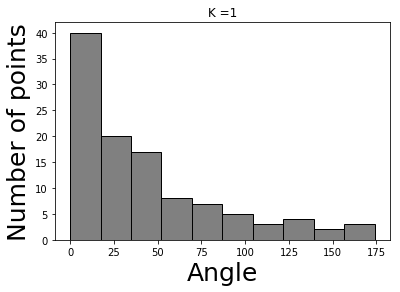

Median Angle Lag: 29.991411297168675
75 Percentile Angle Lag: 59.21042218773787


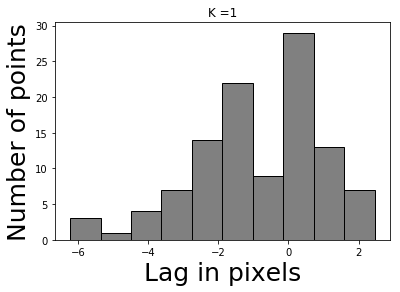

Median Pixel Lag: -0.8021801710226291
Median Relative Pixel Lag: 40.10900855113145
75 Percentile Pixel Lag: 0.07583250119310847
75 Percentile Relative Pixel Lag: 64.76370345059735
2
0


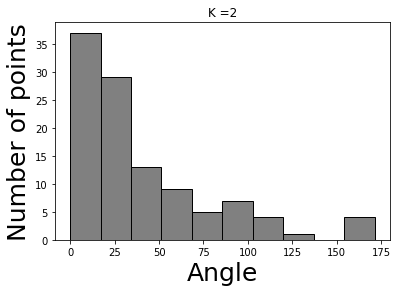

Median Angle Lag: 24.06106990737055
75 Percentile Angle Lag: 58.19476481999542


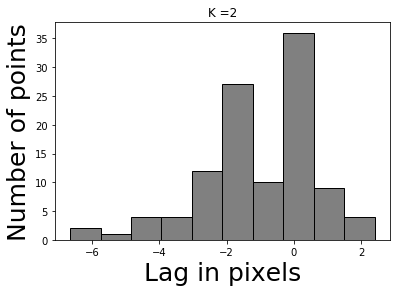

Median Pixel Lag: -0.967687295386185
Median Relative Pixel Lag: 38.00095437426027
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 58.66099819112364
3
0


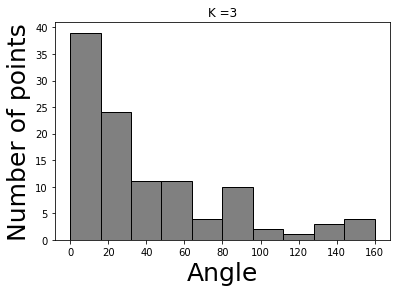

Median Angle Lag: 24.568887538773094
75 Percentile Angle Lag: 53.95731572798516


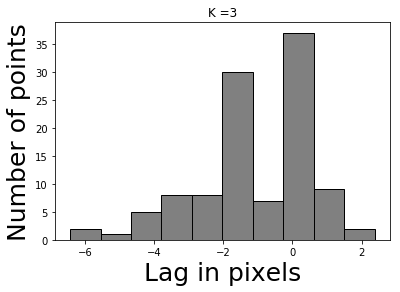

Median Pixel Lag: -1.0738980894792833
Median Relative Pixel Lag: 38.6948719001806
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 58.52179241968892
4
0


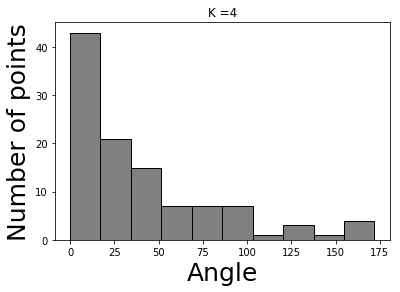

Median Angle Lag: 25.11980468032245
75 Percentile Angle Lag: 56.490178644038245


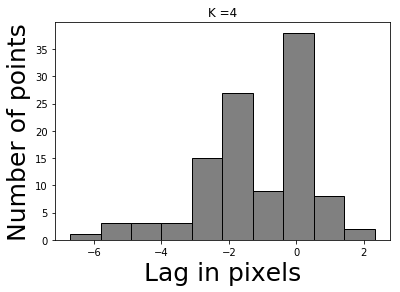

Median Pixel Lag: -1.1327738844579276
Median Relative Pixel Lag: 37.1389536213582
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 60.10882215538893
5
0


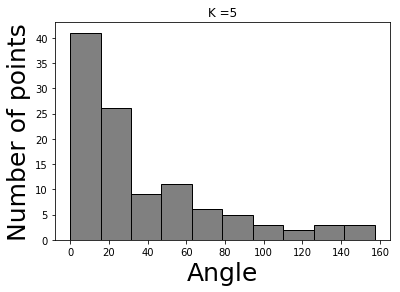

Median Angle Lag: 22.099330893344764
75 Percentile Angle Lag: 55.39351080973145


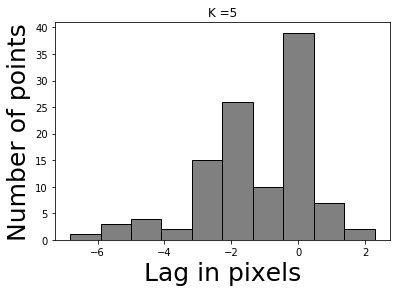

Median Pixel Lag: -1.1206199188610735
Median Relative Pixel Lag: 38.42219994517143
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 61.927837668808394
6
0


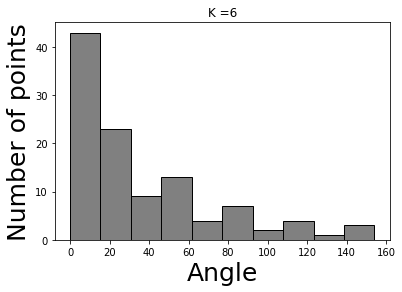

Median Angle Lag: 20.60459328211142
75 Percentile Angle Lag: 52.864607790811185


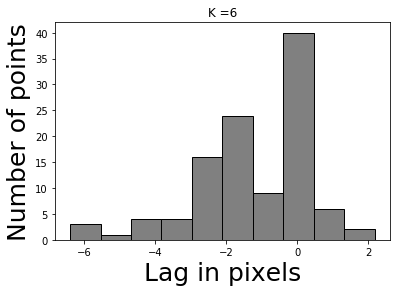

Median Pixel Lag: -1.0398602151181489
Median Relative Pixel Lag: 39.4379098628841
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 58.09282780439452
7
0


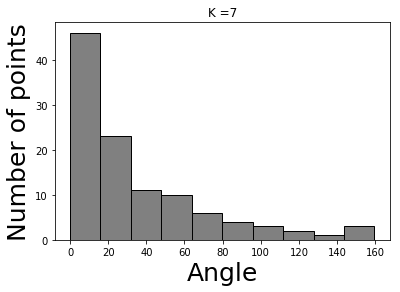

Median Angle Lag: 19.264773328658244
75 Percentile Angle Lag: 49.887505469717645


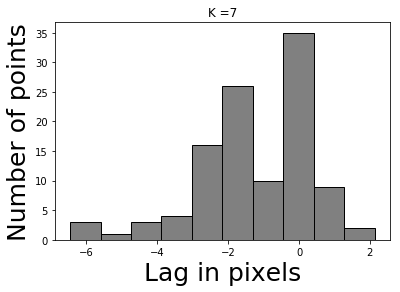

Median Pixel Lag: -1.0509696870096874
Median Relative Pixel Lag: 39.590710201971376
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 58.43302709235031
8
0


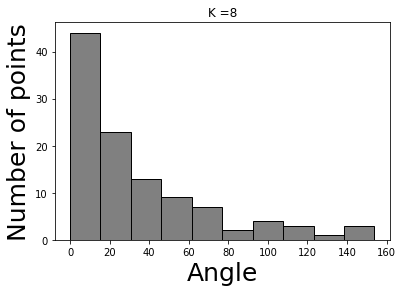

Median Angle Lag: 18.796426571126737
75 Percentile Angle Lag: 48.43852520863274


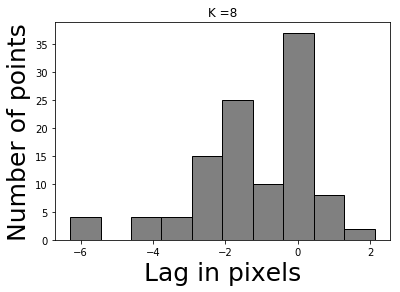

Median Pixel Lag: -1.0608823220700678
Median Relative Pixel Lag: 39.040914934156355
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 56.213150469528514
9
0


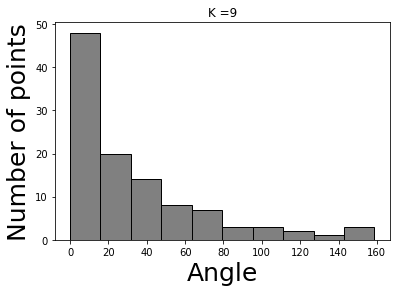

Median Angle Lag: 18.335944203896926
75 Percentile Angle Lag: 47.16369981216456


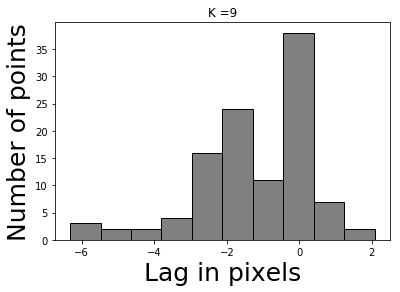

Median Pixel Lag: -1.0092730945586466
Median Relative Pixel Lag: 37.5995767388743
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 56.54544540728361
10
0


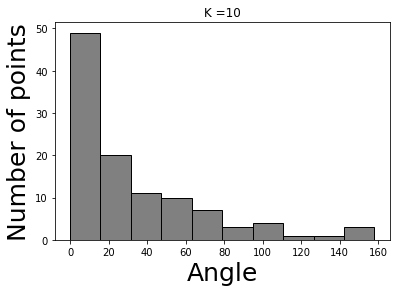

Median Angle Lag: 17.977165930402258
75 Percentile Angle Lag: 49.629736676213355


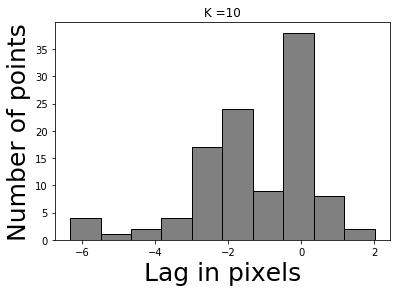

Median Pixel Lag: -1.1339574374855126
Median Relative Pixel Lag: 38.69013864796054
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 57.59882433373087
11
0


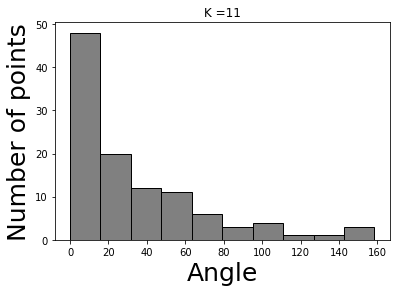

Median Angle Lag: 17.072460679042063
75 Percentile Angle Lag: 49.79346000799964


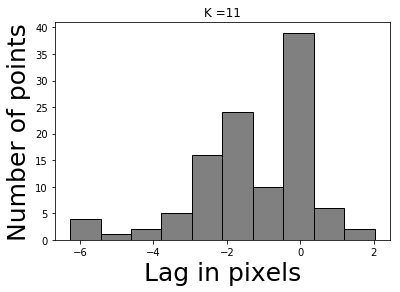

Median Pixel Lag: -1.1603095928041283
Median Relative Pixel Lag: 38.67280561884681
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 56.99243321299268
12
0


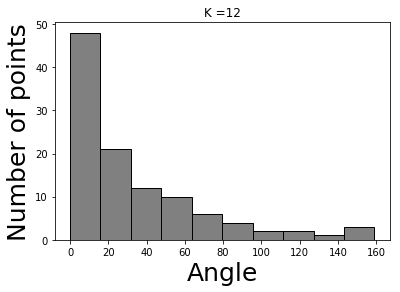

Median Angle Lag: 17.70036798409809
75 Percentile Angle Lag: 48.31418517717205


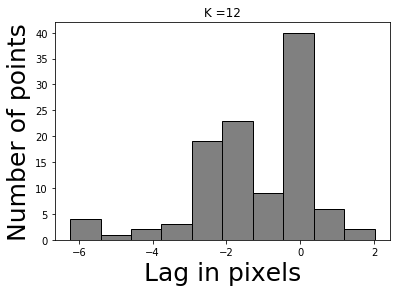

Median Pixel Lag: -1.0110744677230583
Median Relative Pixel Lag: 39.457736700030814
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 56.32875052527551
13
0


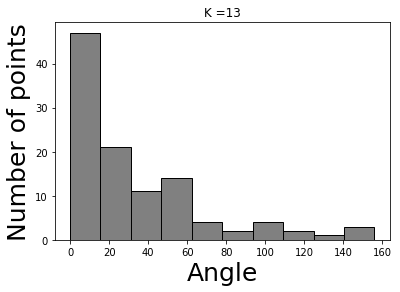

Median Angle Lag: 17.62807811621187
75 Percentile Angle Lag: 49.718004414320205


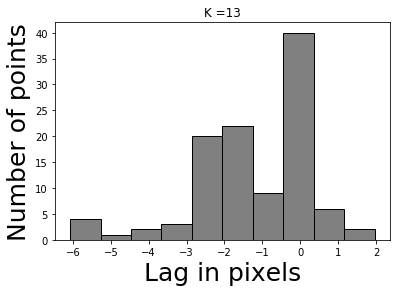

Median Pixel Lag: -1.0040114681306793
Median Relative Pixel Lag: 36.04594596748536
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 55.13829809309894
14
0


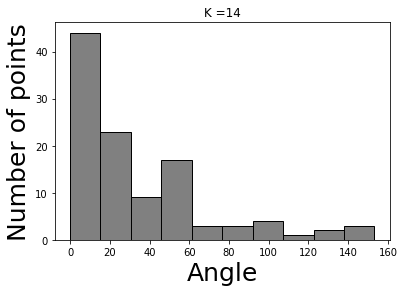

Median Angle Lag: 17.876783281067983
75 Percentile Angle Lag: 49.92093826072847


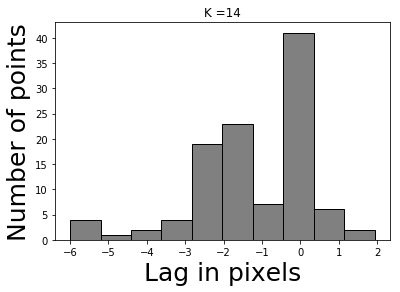

Median Pixel Lag: -1.0130738511659112
Median Relative Pixel Lag: 35.78350498841756
75 Percentile Pixel Lag: 0.0
75 Percentile Relative Pixel Lag: 54.32684731080989


In [25]:
### KD Tree Implementation for NN search and flow compensation (nonSmooth warp)
for k_value in k_list:
    print(k_value)
    avg_flow_x_copy = np.copy(avg_flow_x)
    avg_flow_y_copy = np.copy(avg_flow_y)
    compensated_avg_flow_x, compensated_avg_flow_y = compensate_optical_flow(k_value)
    flow_results_list = prepare_flow_list_for_validation(compensated_avg_flow_x, compensated_avg_flow_y)
    delta = delta_quantification(flow_results_list)
    pixel_lag, relative_pixel_lag = lag_quantification(flow_results_list)
    plot_delta_histogram(delta, k_value)
    print_delta_statistics(delta)
    plot_lag_histogram(pixel_lag, k_value)
    print_lag_statistics(pixel_lag, relative_pixel_lag)

### Vizualization

In [26]:
# fig = plt.figure()
# for element in range(len(starting_points_flat_list)):
# #     plt.plot(starting_points_flat_list[element][0],starting_points_flat_list[element][1],'o',color='white') #Starting position
#     plt.plot(manual_track_points_flat_list[element][0],manual_track_points_flat_list[element][1],'+',color='orange') #Updated position by flow computation
#     plt.plot(flow_points_flat_list[element][0],flow_points_flat_list[element][1],'+',color='red') #Updated position by flow computation
#     plt.imshow(myosin_channel[-1]) 
#     fig.tight_layout()    